In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# pip install copulae

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from scipy.stats import truncnorm, norm, t, expon
from sklearn.model_selection import train_test_split
from copulae.archimedean import ClaytonCopula
from copulae import GaussianCopula

**Название исследования:** <br>
<br>
"**Влияние уровня образования на точность пересказа текста:** инструментальный подход с использованием географической доступности вузов"

### Исследования на всякий случай:
* Ими нужно подтвердить именно связь между зависимой переменной и переменной воздействия. То есть в нашем случае: факт того, что получение высшего образования влиять на развитие способности осознавать и запоминать смысл текста, а потом воспроизводить его с высокой точностью:
    * Flesch–Kincaid readability tests
    * [The Connection Between Reading Comprehension and Cognitive Development. Muhammed Busari, Daniel John, Akande Goodness](https://www.researchgate.net/publication/390564573_The_Connection_Between_Reading_Comprehension_and_Cognitive_Development?utm_source=chatgpt.com)
    * [The effects of university students' fragmented reading on cognitive development](https://pmc.ncbi.nlm.nih.gov/articles/PMC9415515/?utm_source=chatgpt.com)
    * [An Investigation on Effects of University Students' Cognitive Ability on Their Academic Achievement](https://www.researchgate.net/publication/383866802_AN_INVESTIGATION_ON_EFFECTS_OF_UNIVERSITY_STUDENTS%27_COGNITIVE_ABILITY_ON_THEIR_ACADEMIC_ACHIEVEMENT?utm_source=chatgpt.com)

### Описание данных: 

1) **Зависимая переменная (непрерывная: от 0 до 100)**: Процент смысловой точности пересказа (`recall_score`) <br>
В данном исследовании мы будем следить за тем, насколько полно человек воспроизвел смысл прочитанного текста.
2) **Переменная воздействия (бинарная)**: Уровень образования (`higher_edu`) <br>
Бинарная переменная: равна 1, если у человек есть высшее / он в процессе его получения; равна 0, иначе.
3) **Инструментальная переменная (бинарная)**: расстояние до ближайшего университета в школьные годы (`far_from_uni`) <br>
В качестве инструментальной переменной выбрана бинарная переменная: она равна 1, если ближайший (хороший? - условно по любом рейтингу топ-100) университет находится в городе проживания; равна 0, иначе. <br>
Эта переменная:
* **Релевантна**: связана с образованием (люди, живущие ближе к вузу, чаще получают высшее образование),
* **Валидна**: не влияет напрямую на качество пересказа текста, так как не определяет когнитивные способности или привычки чтения.
4) **Эндогенные переменные (бинарные)**: наличие СДВГ (`ahdh`) и концентрация (`low_focus`) <br>
Эндогенность переменной образования обусловлена скрытыми факторами, такими как мотивация, СДВГ или уровень концентрации.
5) **Контрольные переменные (2 непрерывные и 2 бинарные)**: сложность текста (Flesch-Kincaid score / `text_complexity`), возраст (`age`), частота чтения (`reads_often`), отсутствие усталости (`not_tired`) <br>
Переменная, отражающая сложность текста основывается на `Flesch-Kincaid score`. Этот показатель принимает значения от 100 до 0, где 0 - наивысший уровень сложности текста; 100 - в среднем легко воспринимается 11 летними детьми. <br>
**Замечание:** переменная отсутсвия усталости (`not_tired`) была выбрана именно в такой формулировки для согласованности обозначения "плохих событий" для частоты чтения и отсутсвия усталости (чтобы оба обозначались 0 в "плохом" случае). Далее это будет иметь значение.

**Предполагаемые зависимости между переменными:**
* Образование положительно связано с точностью пересказа.
* Сложность текста отрицательно влияет на пересказ.
* Возраст - квадратичная зависимость с точностью пересказа: приближается параболой ветвями вниз с пиком около 25-30 лет.
* Частота чтения — положительное влияние.
* Усталость — отрицательное влияние.

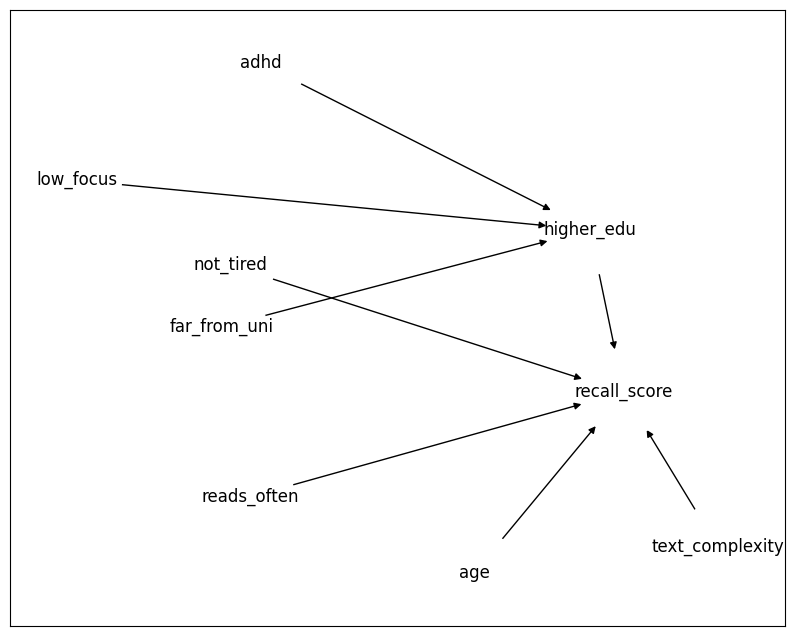

In [4]:
nx_options = {
    'node_color': 'white',
    'node_size': 4000,
    'width': 1,
    'arrowstyle': '-|>',
    'arrowsize': 10,
}

edges = [
    ('higher_edu', 'recall_score'),
    ('text_complexity', 'recall_score'),
    ('age', 'recall_score'),
    ('reads_often', 'recall_score'),
    ('not_tired', 'recall_score'),
    ('far_from_uni', 'higher_edu'),
    ('adhd', 'higher_edu'),
    ('low_focus', 'higher_edu'),

]

G = nx.DiGraph(directed = True)
G.add_edges_from(edges)

plt.figure(figsize=(10, 8))
np.random.seed(666)
nx.draw_networkx(G, arrows = True, **nx_options)

## Симуляция данных

**Описание процессса генерации данных:**
1) Сначала генерируем данные, которые должны быть экзогенными и не зависят от других переменных.
2) Внедряем обоснованное научными исследованиями предположение, что уровень образования (переменная воздейсвтия) зависит от инструментальной переменной (расстояние до ближайшего университета в школьные годы) и от эндогенных (наличие СДВГ и концентрация).
3) Генерируем зависимую переменную в соответствии с математическим процессом, который мы задали изначально.

In [5]:
data = pd.DataFrame(columns = ['recall_score', 'higher_edu', 'far_from_uni', 'adhd', 'low_focus', 'text_complexity', 'age', 'reads_often', 'not_tired'])

### Генерация контрольный переменных

**Контрольные переменные**: сложность текста (Flesch-Kincaid score / `text_complexity`), возраст (`age`), частота чтения (`reads_often`), отсутствие усталости (`not_tired`) стоит генерировать, учитывая взаимосвязи между этими переменными. Для этого применим математический аппарат в виде копул. Как известно, копулы можно поделить на два больших семейства: эллиптические и архимедовы. Первым стоит отдавать предпочтение, если зависимость между переменными симметричная и умеренная, в то время как архимедовы более гибкие в моделировании сложных асимметричных зависимостей. <br>
<br>
Для чистоты эксперимента попробуем посмотреть на оба варианта, выбрав из эллиптических `гауссову копулу`, а из архимедовых - `Клейтона`, так как мы предполагаем, что **важнее правильно моделировать экстремальные нижние значения** (например, при высокой усталости `not_tired = 0` человек предположительно меньше читает `reads_often = 0`). После обучения двух копул выберем одну из них в соответствии с более логичными и объяснимыми с житейской точки зрения результатами.

# Проблема: 
У меня не получается в копулах фиксировать зерно, из-за чего корреляции довольно сильно меняются и выбор между `GaussianCopula` и `ClaytonCopula` тоже может меняться.

In [6]:
n = 5000
np.random.seed(666)
# Предположим, что большинство текстов имеют Flesch–Kincaid в пределах от 30 до 70, то есть 
# предназначены для людей, начиная от школьников 13 лет до студентов. 
# Для того, чтобы это учесть, можно использовать усеченное нормальное распределение.
lower, upper = 0, 100
mu, sigma = 50, 15

a, b = (lower - mu) / sigma, (upper - mu) / sigma
text_complexity = truncnorm(a, b, loc=mu, scale=sigma).rvs(n)

age = np.round(np.random.normal(loc=30, scale=8, size=5000).clip(15, 60)).astype(int)
reads_often = np.random.binomial(1, 0.6, size=n)
not_tired = np.random.binomial(1, 0.7, size=n)

In [7]:
text_complexity_u = truncnorm.cdf(text_complexity, a, b, loc=mu, scale=sigma)
age_u = norm.cdf(age, loc=30, scale=8)
reads_often_u = reads_often
not_tired_u = not_tired

In [8]:
rng = np.random.default_rng(666)

In [9]:
data_uniform = pd.DataFrame({
    'text_complexity': text_complexity_u,
    'age': age_u,
    'reads_often': reads_often_u,
    'not_tired': not_tired_u
})

# Применяем Gaussian Copula
gaussian = GaussianCopula(dim=4)
gaussian.fit(data_uniform)
sample_uniform_gauss = gaussian.random(n)
sample_gauss = pd.DataFrame({
    'text_complexity': truncnorm.ppf(sample_uniform_gauss.iloc[:, 0], a, b, loc=mu, scale=sigma),
    'age': np.round(norm.ppf(sample_uniform_gauss.iloc[:, 1], loc=30, scale=8)).clip(15, 60).astype(int),
    'reads_often': (sample_uniform_gauss.iloc[:, 2] > 0.5).astype(int),
    'not_tired': (sample_uniform_gauss.iloc[:, 3] > 0.5).astype(int)
})

# Применяем Clayton Copula
clayton = ClaytonCopula(dim=4)
clayton.fit(data_uniform)
sample_uniform_clayton = clayton.random(n)
sample_clayton = pd.DataFrame({
    'text_complexity': truncnorm.ppf(sample_uniform_clayton.iloc[:, 0], a, b, loc=mu, scale=sigma),
    'age': np.round(norm.ppf(sample_uniform_clayton.iloc[:, 1], loc=30, scale=8)).clip(15, 65).astype(int),
    'reads_often': (sample_uniform_clayton.iloc[:, 2] > 0.5).astype(int),
    'not_tired': (sample_uniform_clayton.iloc[:, 3] > 0.5).astype(int)
})

       text_complexity          age  reads_often    not_tired
count      5000.000000  5000.000000  5000.000000  5000.000000
mean          0.500000     0.500000     0.500000     0.500000
std           0.288646     0.288426     0.244486     0.229968
min           0.000200     0.018696     0.197960     0.152070
25%           0.250100     0.269546     0.197960     0.152070
50%           0.500000     0.502999     0.697860     0.651970
75%           0.749900     0.740152     0.697860     0.651970
max           0.999800     0.999800     0.697860     0.651970
       text_complexity          age  reads_often    not_tired
count      5000.000000  5000.000000  5000.000000  5000.000000
mean          0.500000     0.500000     0.500000     0.500000
std           0.288646     0.288426     0.244486     0.229968
min           0.000200     0.018696     0.197960     0.152070
25%           0.250100     0.269546     0.197960     0.152070
50%           0.500000     0.502999     0.697860     0.651970
75%     

In [10]:
print("Корреляции Gaussian Copula:")
print(sample_gauss.corr())

print("\nКорреляции Clayton Copula:")
print(sample_clayton.corr())

Корреляции Gaussian Copula:
                 text_complexity       age  reads_often  not_tired
text_complexity         1.000000  0.009525     0.047951  -0.006973
age                     0.009525  1.000000     0.012882   0.014738
reads_often             0.047951  0.012882     1.000000  -0.240652
not_tired              -0.006973  0.014738    -0.240652   1.000000

Корреляции Clayton Copula:
                 text_complexity       age  reads_often  not_tired
text_complexity         1.000000  0.012034     0.026411   0.012389
age                     0.012034  1.000000    -0.004951   0.032714
reads_often             0.026411 -0.004951     1.000000   0.014035
not_tired               0.012389  0.032714     0.014035   1.000000


**Вывод:** с точки зрения логики и интерпретируемости, мы решили выбрать результаты `GaussianColupa`. Это объясняется следующими фактами:
1) Прежде всего нам понравилось, что корреляции везде сравнительно небольшие, это выглядит правдоподобно.
2) Логично, что наибольшая по модулю корреляция наблюдается между `reads_often` и `not_tired`.
3) На втором месте корреляция `text_complexity` и `reads_often`, что тоже логично, так как сложность текста - факт субъективный и он отчасти зависит от частоты чтения человеком.
4) Нет никаких явных логических противоречий в логике направления зависимостей (в случае `ClaytonCopula`, например, странно, что чем больше возраст, тем вероятнее, что человек не уставший). Хотя, конечно, факт направление зависимости `age` и `reads_often` вызывает небольшие подозрения, но явного противоречия нет, так как, возможно, молодые больше читают "вынуждено" (на учебе, на начальных позициях работы, когда они только вникают в происходящее).

In [11]:
data['text_complexity'] = sample_gauss['text_complexity']
data['age'] = sample_gauss['age']
data['reads_often'] = sample_gauss['reads_often']
data['not_tired'] = sample_gauss['not_tired']

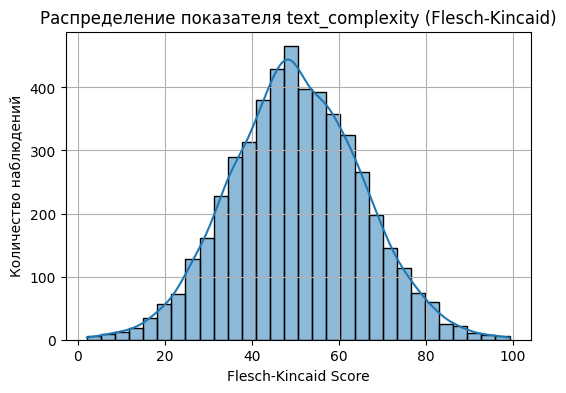

In [12]:
plt.figure(figsize=(6, 4))
sns.histplot(data['text_complexity'], bins=30, kde=True)
plt.title('Распределение показателя text_complexity (Flesch-Kincaid)')
plt.xlabel('Flesch-Kincaid Score')
plt.ylabel('Количество наблюдений')
plt.grid(True)
plt.show()

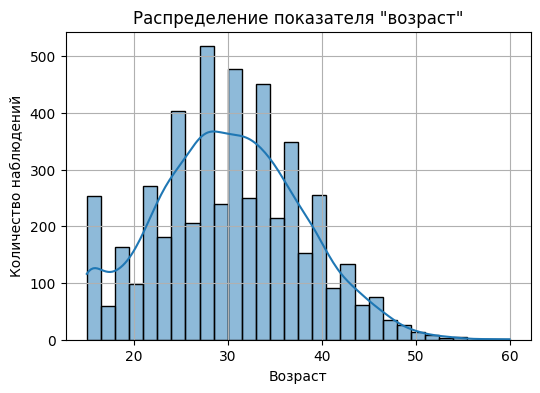

In [13]:
plt.figure(figsize=(6, 4))
sns.histplot(data['age'], bins=30, kde=True)
plt.title('Распределение показателя "возраст"')
plt.xlabel('Возраст')
plt.ylabel('Количество наблюдений')
plt.grid(True)
plt.show()

### Генерация ненаблюдаемых переменных, порождающих эндогенность
Важно учитывать таких переменных, так как они порождают эндогенность из-за сложности их наблюдения.

In [14]:
data['adhd'] = np.random.binomial(1, 0.15, size=n)
data['low_focus'] = np.random.binomial(1, 0.3, size=n)
# Для правдоподобности учтем, что у людей с СДВГ всегда проблемы с концентрацией
data.loc[(data['adhd'] == 1), 'low_focus'] = 1

In [15]:
data.columns

Index(['recall_score', 'higher_edu', 'far_from_uni', 'adhd', 'low_focus',
       'text_complexity', 'age', 'reads_often', 'not_tired'],
      dtype='object')

### Генерация инстурментальной переменной
**Как было сказано ранее:** В качестве инструментальной переменной выбрана бинарная переменная (`far_from_uni`): она равна 1, если ближайший (хороший? - условно по любом рейтингу топ-100) университет находится в городе проживания; равна 0, иначе. <br>
<br>
**Важно:** В нашем случае инструментальная переменная `far_from_uni` не зависит от ни от каких других переменных (из числа сгенерированных ранее): в частности, не зависит от контрольных переменных. В том числе не наблюдается и обратной причинности, как бы мы не пытались ее найти, усложнив генерацию данных и приблизив ее к чему-то реалистичному. Единственная связь, которая может быть в данных - обратная причинность у `far_from_uni` с `higher_edu`, но последняя переменная является переменной воздействия и она будет сгенерирована позже. Поэтому в нашей теоретической модели инструментальная переменная будет сгенерирована независимо:

In [16]:
data['far_from_uni'] = np.random.binomial(1, 0.4, size=n)

### Генерация переменной воздействия

Логично предположить, что условные вероятности переменной воздействия **`higher_edu`** зависят от контрольных переменных **`age`**, **`reads_often`**, инструментальной переменной **`far_from_uni`** и ненаблюдаемой латентной переменной **`ahdh`**. <br>
Обозначим **условную вероятность получения высшего образования** для индивида i как:
$$P(\text{higher_edu}_i = 1|adhd_i, age_i, \text{reads_often}_i, \text{far_from_uni}_i) = F_{Logistic}(\alpha_0 + \alpha_1*adhd_i + \alpha_2*age_i + \alpha_3*\text{reads_often}_i + \alpha_4*\text{far_from_uni}_i)$$
Где $F_{\text{Logistic}}$ - функция распределения стандартного логистического распределения. <br>
<br>
Для упрощения введём обозначения условных вероятностей получения высшего образования при разных значениях инструмента:
$$p_{k}^{\text{far_from_uni}_{i}} = P(\text{higher_edu}_{i} = 1|\text{ahdh}_{i}, \text{age}_{i}, \text{often_reads}_{i}, \text{far_from_uni}_{i} = k)\text{, где }k\in\{0,1\}$$
<br>
Для моделирования латентных склонностей введём случайную величину $U_{i}\sim U(0,1)$, независимую от остальных переменных, и **определим потенциальные уровни образования индивида в зависимости от значения инструмента**:
$$\text{higher_edu}_{1i} = I(p_{1}^{\text{far_from_uni}_{i}}\geq U_{i})$$

$$\text{higher_edu}_{0i} = I(p_{0}^{\text{far_from_uni}_{i}}\geq U_{i})$$
где 
$$\text{higher_edu}_{i} = \begin{cases} \text{higher_edu}_{1i}, \text{eсли far_from_uni}_i = 1\\\text{higher_edu}_{0i}, \text{eсли far_from_uni}_i = 0\end{cases}$$
Этот подход позволяет чётко выделить влияние инструментальной переменной на вероятность получения высшего образования и учесть индивидуальные латентные склонности. Так что потом данное разделение можно будет удобно имплементировать при анализе $\text{LATE}$.

In [81]:
higher_edu = np.zeros(len(data))
logit_1 = (-2.0 - 1.0 * data.loc[:, 'adhd'] 
           + 0.02 * data.loc[:, 'age'] 
           + 0.3 * data.loc[:, 'reads_often'] +
           + 3 * data.loc[:, 'far_from_uni'])

logit_0 = (-1.0 - 0.8 * data.loc[:, 'adhd'] 
           + 0.015 * data.loc[:, 'age'] 
           + 0.2 * data.loc[:, 'reads_often'])

# Логистическая функция для вероятностей
p_1 = 1 / (1 + np.exp(-logit_1))
p_0 = 1 / (1 + np.exp(-logit_0))

np.random.seed(666)
U = np.random.uniform(0, 1, size=len(data))
higher_edu[data['far_from_uni'] == 1] = (U[data['far_from_uni'] == 1] <= p_1[data['far_from_uni'] == 1]).astype(int)
higher_edu[data['far_from_uni'] == 0] = (U[data['far_from_uni'] == 0] <= p_0[data['far_from_uni'] == 0]).astype(int)

higher_edu_1 = (U <= p_1).astype(int)
higher_edu_0 = (U <= p_0).astype(int)

data['higher_edu'] = higher_edu.astype(int)

### Интерпретации коэффициентов:

Для группы, живущей далеко от университета (`far_from_uni = 1`): <br>
<br>
**Константа (-2.0)**: более низкий базовый уровень логитов, указывающий на меньшую вероятность получить высшее образование по сравнению с теми, кто живёт ближе.

**Коэффициент при `adhd` (-1.0)**: наличие СДВГ значительно снижает шансы получить образование. Больше, чем у тех, кто живет близко к университету, в силу того, что СДВГ может увеличивать барьеры для решения о переезде.

**Коэффициент при `age` (+0.02)**: с ростом возраста вероятность получения образования слегка увеличивается.

**Коэффициент при `reads_often` (+0.3)**: частое чтение существенно повышает шансы получить высшее образование.

Для группы, живущей в городе, где есть университет, входящий в топ-100 (`far_from_uni = 0`): <br>
<br>
**Константа (-1.0)**: более высокий базовый уровень логитов, что соответствует более высокой базовой вероятности получения высшего образования.

**Коэффициент при `adhd` (-0.8)**: наличие СДВГ значительно снижает шансы получить образование

**Коэффициент при `age` (+0.015)**: возраст положительно влияет на вероятность образования, но эффект чуть слабее, чем у удалённых.

**Коэффициент при `reads_often` (+0.2)**: положительный эффект частого чтения на получение образования, но менее выраженный, чем у тех, кто живёт далеко. 

### Генерация для будущей оценки LATE
Надо сгенерировать целевую переменную (`recall_score`) в зависимости от значения бинарной переменной воздействия (`higher_edu`).

In [83]:
# Сгенерируем целевую переменную в отсутствии высшего образования (`higher_edu=0`)
# ошибки будут более шумные
error0 = t.rvs(df=5, size=n)
g0_obs = (20 +
          0.3 * data['text_complexity'] + 
          5 * data['reads_often'] +
          0.5 * data['age'] -
          0.008 * (data['age'] ** 2) +
          4.5 * data['not_tired'])
g0_unobs = -4.8 * data['adhd'] -6.5 * data['low_focus']

recall_score_0 = g0_obs + g0_unobs + error0

# Потенциальный recall при наличии высшего образования (`higher_edu=1`)
# ошибки с меньшей вариативностью
error1 = np.random.normal(loc=0, scale=1.5, size=n)
g1_obs = (30 +
          0.4 * data['text_complexity'] + 
          4 * data['reads_often'] +
          0.55 * data['age'] -
          0.009 * (data['age'] ** 2) +
          5 * data['not_tired'])
g1_unobs = -4.8 * data['adhd'] -6.5 * data['low_focus']

recall_score_1 = g1_obs + g1_unobs + error1

### Итоговая модель

In [84]:
recall_score_0 = np.clip(recall_score_0, 0, 100)
recall_score_1 = np.clip(recall_score_1, 0, 100)

data['recall_score'] = recall_score_1 * data['higher_edu'] + recall_score_0 * (1 - data['higher_edu'])

In [85]:
unavailable_info = pd.concat([pd.Series(recall_score_1, name='recall_score_1'), 
                               pd.Series(recall_score_0, name='recall_score_0'),
                               pd.Series(higher_edu_1, name='higher_edu_1'),
                               pd.Series(higher_edu_0, name='higher_edu_0')
                            ], axis=1)

ind_type = np.empty(unavailable_info.shape[0], dtype = 'U25')
ind_type[(higher_edu_1 == 1) & (higher_edu_0 == 1)] = 'Always taker'
ind_type[(higher_edu_1 == 0) & (higher_edu_0 == 0)] = 'Never taker'
ind_type[higher_edu_1 > higher_edu_0]               = 'Complier'
ind_type[higher_edu_1 < higher_edu_0]               = 'Denier'

unavailable_info = pd.concat([unavailable_info, pd.Series(ind_type, name='ind_type')], axis=1)

In [87]:
unavailable_info['ind_type'].value_counts()

ind_type
Never taker     2249
Always taker    1382
Complier         880
Denier           489
Name: count, dtype: int64

In [ ]:
# Экспорт итогового датасета
data.to_csv('edu_text_recall_data.csv', encoding='utf-8', index=False)

unavailable_info.to_csv('unavailable_info.csv', encoding='utf-8', index=False)

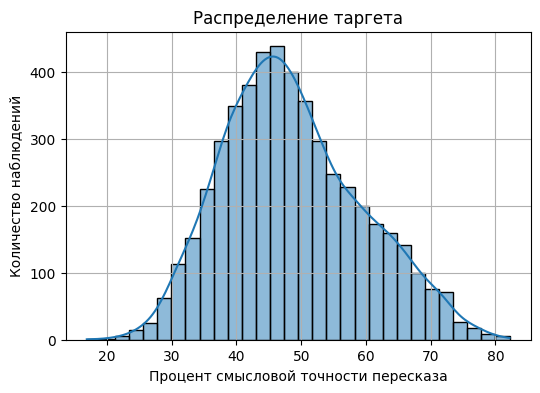

In [22]:
plt.figure(figsize=(6, 4))
sns.histplot(data['recall_score'], bins=30, kde=True)
plt.title('Распределение таргета')
plt.xlabel('Процент смысловой точности пересказа')
plt.ylabel('Количество наблюдений')
plt.grid(True)
plt.show()

In [23]:
data[data['recall_score'] == data['recall_score'].min()]

,recall_score,higher_edu,far_from_uni,adhd,low_focus,text_complexity,age,reads_often,not_tired
4916,16.8691,0,0,1,1,6.858582,26,0,0


In [24]:
data[data['recall_score'] == data['recall_score'].max()]

,recall_score,higher_edu,far_from_uni,adhd,low_focus,text_complexity,age,reads_often,not_tired
3508,82.189999,1,1,0,0,84.081354,38,1,1


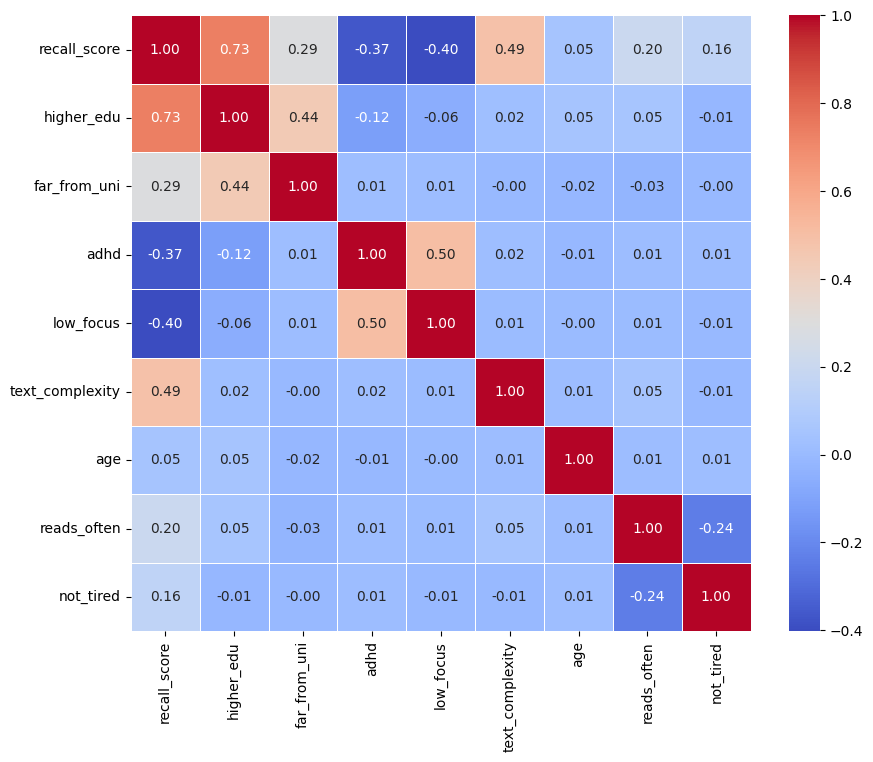

In [91]:
correlation = data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, fmt=".2f", cmap="coolwarm", linewidths=0.5, annot=True)
plt.show()

## Статистика 

In [25]:
continuous_vars = ['text_complexity', 'age', 'recall_score']
binary_vars = ['higher_edu', 'far_from_uni', 'adhd', 'low_focus', 'reads_often', 'not_tired']

continuous_stats = data[continuous_vars].agg(['mean', 'std', 'median', 'min', 'max']).T
continuous_stats.columns = ['mean', 'std', 'median', 'min', 'max']

binary_stats = pd.DataFrame({'share_of_ones': data[binary_vars].mean(), 'count_of_ones': data[binary_vars].sum()})

In [26]:
continuous_stats

,mean,std,median,min,max
text_complexity,50.196276,14.928224,49.897387,2.091422,99.179497
age,30.056200,7.775161,30.000000,15.000000,60.000000
recall_score,48.599833,10.707844,47.382025,16.869100,82.189999


In [27]:
binary_stats

,share_of_ones,count_of_ones
higher_edu,0.3124,1562
far_from_uni,0.3930,1965
adhd,0.1468,734
low_focus,0.4042,2021
reads_often,0.4934,2467
not_tired,0.5074,2537


## Деление на обучающую и тестовую выборки

In [28]:
train, test = train_test_split(data, test_size=0.25, random_state=666)

In [29]:
train

,recall_score,higher_edu,far_from_uni,adhd,low_focus,text_complexity,age,reads_often,not_tired
3198,53.895042,1,0,0,0,24.446805,21,1,0
2985,44.728035,0,1,0,0,47.847987,26,0,1
2668,44.831563,0,1,0,0,47.789516,24,0,1
2015,48.279914,0,1,0,0,51.110548,23,0,1
501,46.596066,0,0,0,1,69.403926,25,1,0
...,...,...,...,...,...,...,...,...,...
1993,33.776908,0,0,0,0,17.174274,30,0,0
70,35.596904,0,0,0,0,14.985999,19,1,0
2878,61.594218,1,0,0,1,71.928004,28,0,0
1950,60.041921,1,0,0,0,38.855755,27,0,1


## Дополнительный анализ

Можно будет вставить сюда разные графики

In [30]:
data['recall_score'].min()

16.869100311402626